In [28]:
import warnings

# Игнорирование FutureWarning и UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
DATASET = r'dataset\\Первичная выгрузка Станки Загрузка по дням.xlsx'

In [31]:
df = pd.read_excel(DATASET)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24291 entries, 0 to 24290
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   Объект                                      24291 non-null  object        
 1   Дата                                        24290 non-null  datetime64[ns]
 2   Аварийная остановка, ч.                     24057 non-null  float64       
 3   Прогрев станка, ч.                          24057 non-null  float64       
 4   Серийное производство, ч.                   24057 non-null  float64       
 5   Отработка программы, ч.                     24057 non-null  float64       
 6   Ручной режим, ч.                            24057 non-null  float64       
 7   Станок под нагрузкой, ч.                    9239 non-null   float64       
 8   Программа выполняется, ч.                   24057 non-null  float64       
 9   Авария

In [33]:
df = df.iloc[:-1]

In [ ]:
df['Аварийная остановка, ч.'] = df['Аварийная остановка, ч.'].astype(str).str.replace(',', '.').astype(float)

In [40]:
df_cleaned = df.dropna(subset=['Аварийная остановка, ч.'])

In [ ]:
# import seaborn as sns
# sns.boxplot(x=df_cleaned['Аварийная остановка, ч.']);

In [ ]:
# df_cleaned['Аварийная остановка, ч.'].describe()

In [ ]:
# df.info()

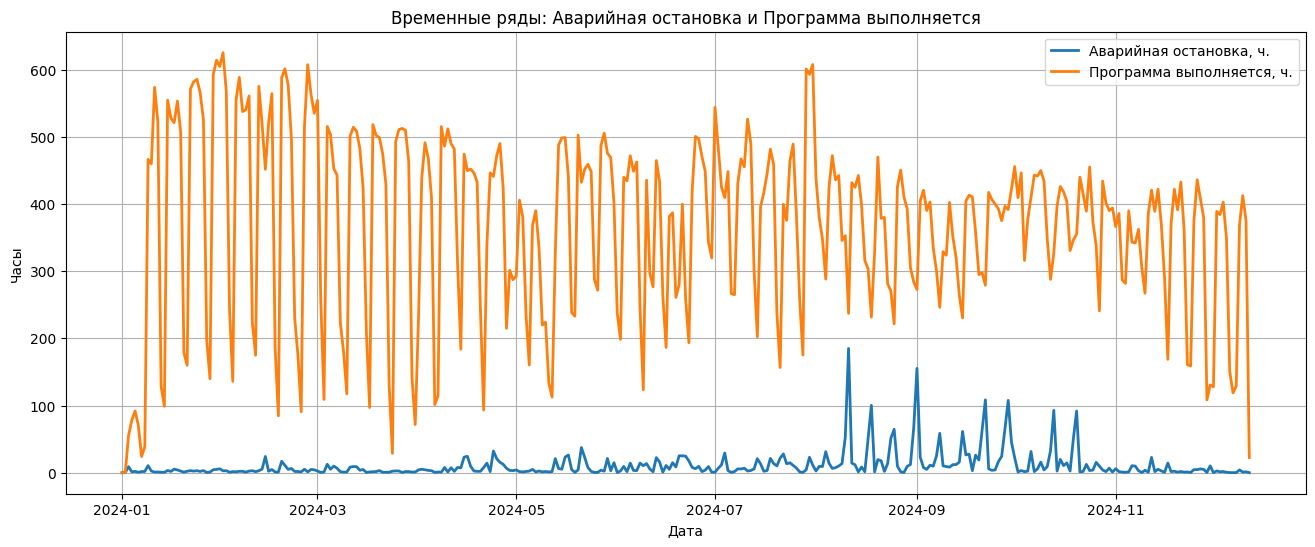

In [51]:
# # Преобразуем столбец "Дата" в формат datetime
# df['Дата'] = pd.to_datetime(df['Дата'])

# Агрегируем данные по дате (берем сумму значений по всем объектам)
df_aggregated = df.groupby('Дата')[['Аварийная остановка, ч.', 'Программа выполняется, ч.']].sum()

# Строим график временного ряда
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.", linewidth=2)
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()


In [77]:
from statsmodels.tsa.stattools import adfuller

def check_stationary(column):
    result = adfuller(column.dropna())
    p_value = result[1]
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {p_value}")
    if p_value < 0.05:
        print(f'Ряд является стационарным')
    else:
        print(f'Ряд не является стационарным')

check_stationary(df_aggregated['Аварийная остановка, ч.'])
check_stationary(df_aggregated['Программа выполняется, ч.'])


# result = adfuller(df_aggregated['Аварийная остановка, ч.'])

# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))
    

# result = adfuller(df_aggregated['Программа выполняется, ч.'])

# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
#     print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.01301341334377
p-value: 1.7582918958711622e-17
Ряд является стационарным
ADF Statistic: -2.179162681641589
p-value: 0.21389492896947093
Ряд не является стационарным


In [80]:
df_aggregated['Аварийная остановка, ч.'] = df_aggregated['Аварийная остановка, ч.'].diff().dropna()
df_aggregated['Программа выполняется, ч.'] = df_aggregated['Программа выполняется, ч.'].diff().dropna()
check_stationary(df_aggregated['Аварийная остановка, ч.'])
check_stationary(df_aggregated['Программа выполняется, ч.'])

ADF Statistic: -14.132199164331416
p-value: 2.323127922501946e-26
Ряд является стационарным
ADF Statistic: -7.539565999364586
p-value: 3.406454853194566e-11
Ряд является стационарным


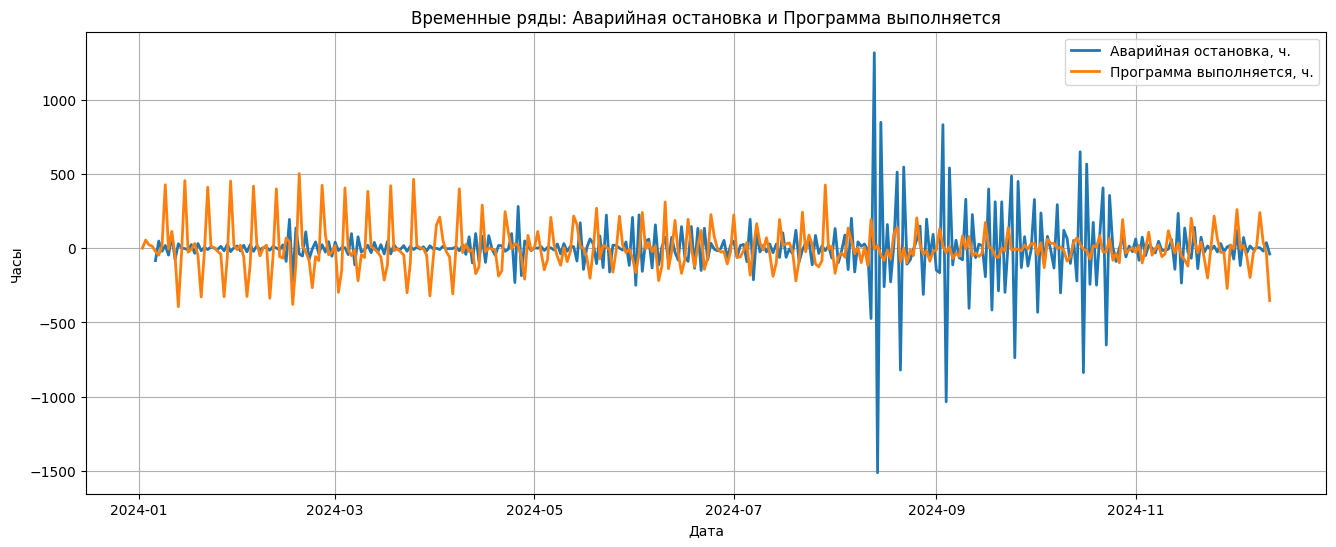

In [81]:
plt.figure(figsize=(16, 6))
plt.plot(df_aggregated.index, df_aggregated['Аварийная остановка, ч.'], label="Аварийная остановка, ч.", linewidth=2)
plt.plot(df_aggregated.index, df_aggregated['Программа выполняется, ч.'], label="Программа выполняется, ч.", linewidth=2)
plt.xlabel("Дата")
plt.ylabel("Часы")
plt.title("Временные ряды: Аварийная остановка и Программа выполняется")
plt.legend()
plt.grid(True)
plt.show()

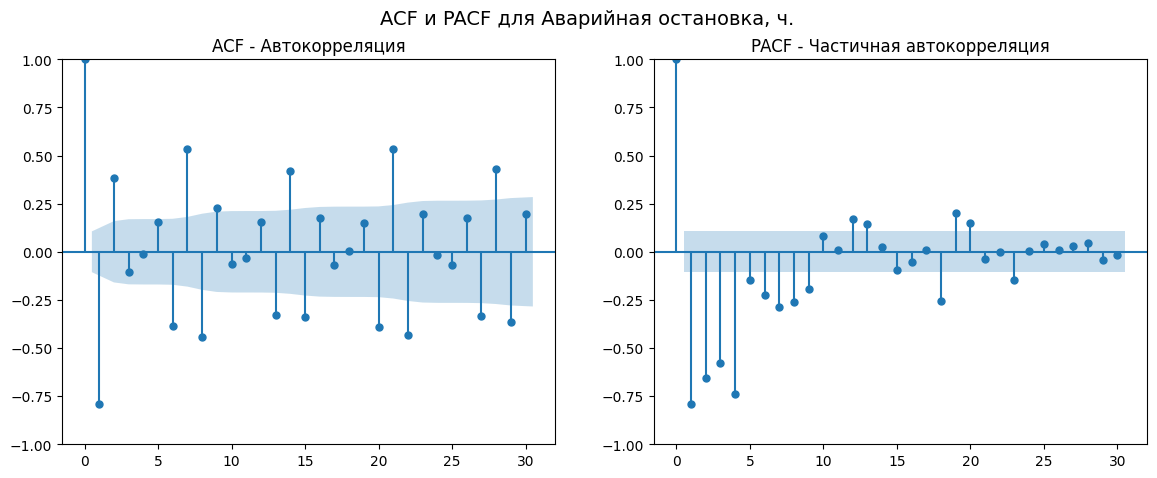

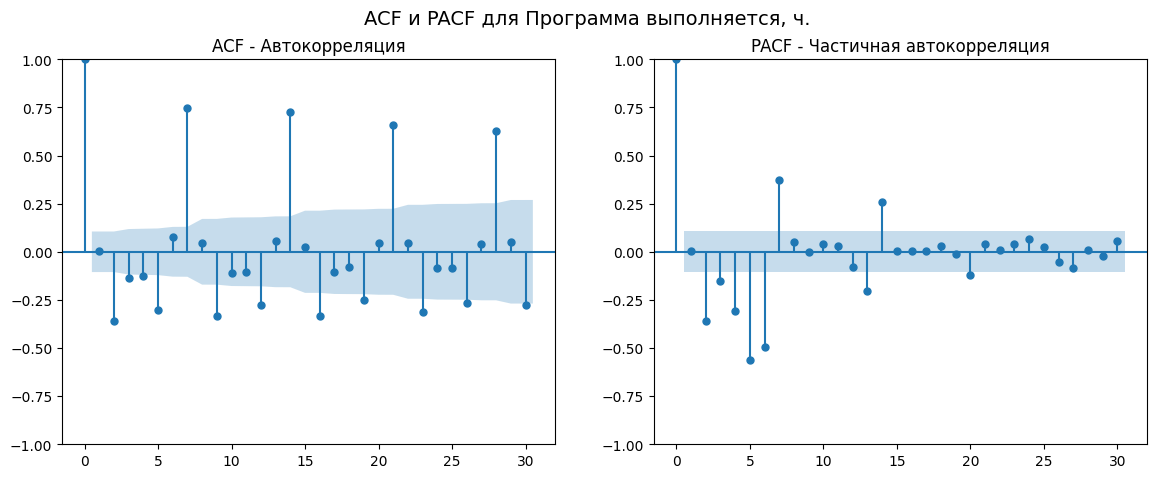

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def built_acf_and_pacf(df, column_names):
    for col in column_names:
        series = df[col].dropna()  # Берем только один столбец и удаляем NaN

        # Строим ACF и PACF
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        plot_acf(series, lags=30, ax=axes[0])  # ACF для выбора q
        axes[0].set_title("ACF - Автокорреляция")

        plot_pacf(series, lags=30, ax=axes[1])  # PACF для выбора p
        axes[1].set_title("PACF - Частичная автокорреляция")

        # Добавляем общий заголовок
        fig.suptitle(f"ACF и PACF для {col}", fontsize=14)

        plt.show()  # Отображаем графики

# Выбираем стационарные ряды
column_names = ["Аварийная остановка, ч.", "Программа выполняется, ч."]
built_acf_and_pacf(df_aggregated, column_names)